# Notebook for generating synthetic user bios 

- Each user will have age, description, nationality, gender
- Mixture of depression, anxiety, depression
- An embedding vector will be generated using gemini for each user for later calculating similarity with user-input data


In [90]:
from random_username.generate import generate_username
import google.generativeai as genai
import random
import pandas as pd 
import os
from tqdm import tqdm as tqdm
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D 
import textwrap
os.chdir("/Users/AdamHarris/Documents/GitRepos/RoboSmile_Intervention/")

In [56]:
GOOGLE_API_KEY = YOUR_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)
model_bio = genai.GenerativeModel('gemini-1.5-flash')

In [57]:
conditions = ['Depression', 'Anxiety', 'Psychosis']
management_levels = ['High', 'Medium', 'Low']
management_types = ['Medication', 'Therapy', 'Both', 'None']
sex_options = ['Male', 'Female', 'Non-binary', 'Prefer not to say']
age_bins = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
education = ['High school', 'Some college', "Bachelor's", "Graduate degree"]

In [69]:

NUM_USERS_PER_CONDITION = 100

synthetic_users_data = []

for condition in conditions:
    print(f"Generating data for {condition}")
    for user_num in tqdm(range(NUM_USERS_PER_CONDITION)):
        
        USERNAME = generate_username(1)[0]
        CONDITION = condition
        MANAGEMENT_LEVEL = random.choice(management_levels)
        MANAGEMENT_TYPE = random.choice(management_types)
        SEX = random.choice(sex_options)
        AGE = random.choice(age_bins)
        EDUCATION = random.choice(education)

        USER_BIO_PROMPT = f"Write a short bio about yourself, only a few sentences to a paragraph. \
            You are a user signing up to an online mental health support group.\
            You identify as {SEX}\
            Your are signing up because you are suffering from {CONDITION}.\
            You are looking for a community of people who can relate to your experiences and provide support, or provide support yourself.\
            Your level of management of your condition is {MANAGEMENT_LEVEL} using {MANAGEMENT_TYPE} strategy."


        response = model_bio.generate_content(USER_BIO_PROMPT)
        BIO = response.text
        EMBEDDING = genai.embed_content(model="models/text-embedding-004",
                            content=BIO)


        synthetic_users_data.append({
            "USERNAME": USERNAME,
            "CONDITION": CONDITION,
            "MANAGEMENT_LEVEL": MANAGEMENT_LEVEL,
            "MANAGEMENT_TYPE": MANAGEMENT_TYPE,
            "SEX": SEX,
            "AGE": AGE,
            "EDUCATION": EDUCATION,
            "BIO": BIO,
            "EMBEDDING": EMBEDDING['embedding']  
        })

test_handwritten_bio = r"I'm 25 and struggling with depression with anxiety. \
                        I'm a college student and would say i'm not coping with it so well.\
                        I am trying talking therapy currently but not keen on medication."

EMBEDDING = genai.embed_content(model="models/text-embedding-004",
                            content=test_handwritten_bio)

synthetic_users_data.append({
            "USERNAME": 'TEST_USER',
            "CONDITION": 'TEST',
            "MANAGEMENT_LEVEL": 'TEST',
            "MANAGEMENT_TYPE": 'TEST',
            "SEX": 'TEST',
            "AGE": 'TEST',
            "EDUCATION": 'TEST',
            "BIO": test_handwritten_bio,
            "EMBEDDING": EMBEDDING['embedding']  
        })

     
df = pd.DataFrame(synthetic_users_data)

# Display or save the DataFrame
print(df.head())
df.to_csv(f"Dataset/synthetic_user_data.csv", index=False)
        

Generating data for Depression


100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


Generating data for Anxiety


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


Generating data for Psychosis


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


            USERNAME   CONDITION MANAGEMENT_LEVEL MANAGEMENT_TYPE  \
0   wrathfulChowder6  Depression           Medium      Medication   
1       trustingPup2  Depression           Medium            None   
2  relievedDinosaur5  Depression             High      Medication   
3      gutturalWasp8  Depression             High            None   
4     amazedCordial4  Depression           Medium            None   

                 SEX    AGE        EDUCATION  \
0             Female  25-34       Bachelor's   
1             Female  45-54      High school   
2         Non-binary  25-34  Graduate degree   
3               Male  55-64      High school   
4  Prefer not to say  45-54       Bachelor's   

                                                 BIO  \
0  I'm a woman seeking support for depression.  I...   
1  I'm a female seeking support for depression.  ...   
2  I'm a non-binary individual seeking support fo...   
3  I'm a male identifying as such, struggling wit...   
4  I'm new here 

In [94]:
df["BIO"][2]

"I'm a non-binary individual seeking support for depression.  My depression is currently well-managed with medication, but I'm looking to connect with others who understand the challenges of mental health, specifically within the non-binary community. I hope to find a supportive environment where I can share my experiences and offer support to others as well.\n"

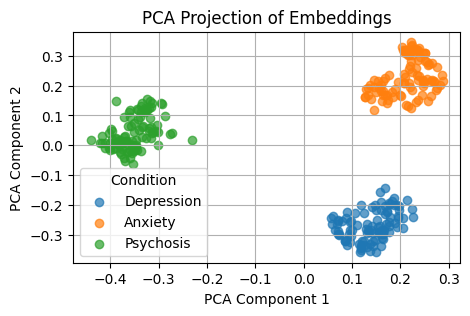

In [82]:
# Step 1: Stack the embedding vectors into a matrix
embedding_matrix = np.vstack(df['EMBEDDING'].values)

# Step 2: Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_matrix)

# Step 3: Add the 2D projection to the DataFrame
df['PCA1'] = embedding_2d[:, 0]
df['PCA2'] = embedding_2d[:, 1]

# Step 4: Plot the 2D projection, coloring by 'CONDITION'
plt.figure(figsize=(5, 3))
for condition in df['CONDITION'].unique():
    if condition == 'TEST':
        continue
        subset = df[df['CONDITION'] == condition]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=condition, c='red', alpha=0.7)
    else:
        subset = df[df['CONDITION'] == condition]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=condition, alpha=0.7)


plt.title('PCA Projection of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Condition')
plt.grid(True)
plt.show()


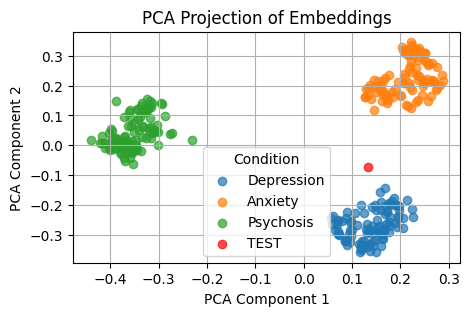

In [83]:
plt.figure(figsize=(5, 3))
for condition in df['CONDITION'].unique():
    if condition == 'TEST':
        subset = df[df['CONDITION'] == condition]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=condition, c='red', alpha=0.7)
    else:
        subset = df[df['CONDITION'] == condition]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=condition, alpha=0.7)


plt.title('PCA Projection of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Condition')
plt.grid(True)
plt.show()

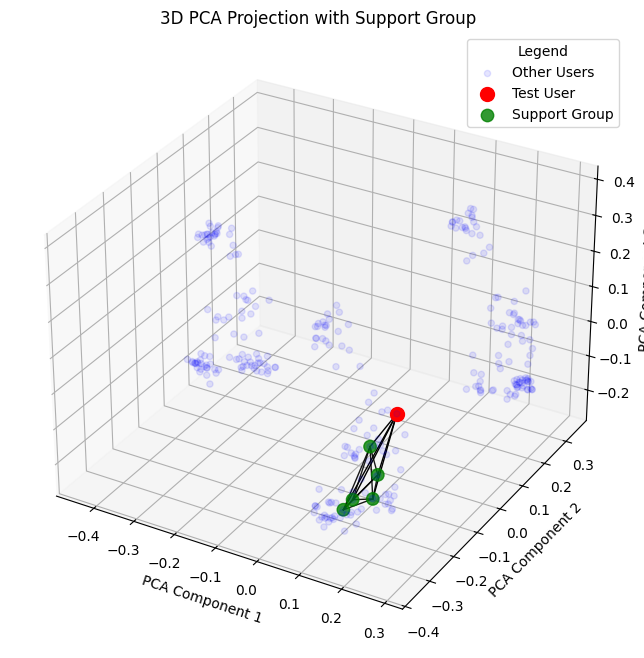

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Locate the test user in the DataFrame
test_user_row = df[df['USERNAME'] == 'TEST_USER']

if test_user_row.empty:
    raise ValueError("Test user with username 'TEST_USER' not found in the dataset.")

# Extract the embedding of the test user
test_embedding = np.array(test_user_row['EMBEDDING'].iloc[0])

# Step 1: Stack embeddings into a matrix and calculate distances
embedding_matrix = np.vstack(df['EMBEDDING'].values)
distances = euclidean_distances([test_embedding], embedding_matrix).flatten()

# Step 2: Find the 5 nearest neighbors (excluding the test user itself)
nearest_indices = distances.argsort()[1:6]  # Exclude the test user itself (index 0)

# Step 3: Perform PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
embedding_3d = pca.fit_transform(embedding_matrix)

# Add PCA results back to the DataFrame
df['PCA1'] = embedding_3d[:, 0]
df['PCA2'] = embedding_3d[:, 1]
df['PCA3'] = embedding_3d[:, 2]

# Get the PCA coordinates of the test user and its neighbors
test_3d = embedding_3d[test_user_row.index[0]]
neighbors_3d = embedding_3d[nearest_indices]

# Step 4: Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all users with high transparency
ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], color='blue', alpha=0.1, label='Other Users')

# Plot the test user in red
ax.scatter(test_3d[0], test_3d[1], test_3d[2], color='red', label='Test User', s=100, zorder=3)

# Plot the neighbors with higher opacity
ax.scatter(neighbors_3d[:, 0], neighbors_3d[:, 1], neighbors_3d[:, 2], color='green', alpha=0.8, label='Support Group', s=80, zorder=2)

# Draw lines from the test user to each neighbor
for neighbor in neighbors_3d:
    ax.plot([test_3d[0], neighbor[0]], [test_3d[1], neighbor[1]], [test_3d[2], neighbor[2]], color='black', linewidth=1)

# Draw faint grey lines between neighbors (graph structure)
for i, point1 in enumerate(neighbors_3d):
    for point2 in neighbors_3d[i + 1:]:
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], color='black', linewidth=1, alpha=0.9)

# Add plot details
ax.set_title('3D PCA Projection with Support Group')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend(title='Legend')
plt.show()


In [86]:
# Locate the test user in the DataFrame
test_user_row = df[df['USERNAME'] == 'TEST_USER']
if test_user_row.empty:
    raise ValueError("Test user with username 'TEST_USER' not found in the dataset.")

# Extract the embedding of the test user
test_embedding = np.array(test_user_row['EMBEDDING'].iloc[0])

# Step 1: Stack embeddings into a matrix and calculate distances
embedding_matrix = np.vstack(df['EMBEDDING'].values)
distances = euclidean_distances([test_embedding], embedding_matrix).flatten()

# Step 2: Find the 5 nearest neighbors (excluding the test user itself)
nearest_indices = distances.argsort()[1:6]  # Exclude the test user itself (index 0)

# Get the indices of the test user and its neighbors
test_user_index = test_user_row.index[0]
support_group_indices = [test_user_index] + list(nearest_indices)

# Step 3: Create a new DataFrame for the test user and their support group
support_group_df = df.iloc[support_group_indices].copy()



In [87]:
support_group_df

,USERNAME,CONDITION,MANAGEMENT_LEVEL,MANAGEMENT_TYPE,SEX,AGE,EDUCATION,BIO,EMBEDDING,PCA1,PCA2,PCA3
300,TEST_USER,TEST,TEST,TEST,TEST,TEST,TEST,I'm 25 and struggling with depression with anx...,"[0.08145237, -0.03191766, -0.04012079, -0.0002...",0.133006,-0.074214,-0.044866
30,shamefulBustard5,Depression,Low,Medication,Male,35-44,Some college,I'm a male struggling with depression and curr...,"[0.08138412, -0.041792393, -0.0104156835, 0.00...",0.176141,-0.258617,-0.002927
63,sadMare2,Depression,Low,Therapy,Prefer not to say,45-54,Graduate degree,I'm new to this group and prefer not to disclo...,"[0.057877738, -0.043408327, -0.042225085, -0.0...",0.160027,-0.217992,-0.182219
93,soreRelish5,Depression,Low,Medication,Prefer not to say,65+,Bachelor's,I'm new here and prefer not to disclose my per...,"[0.06890774, -0.048843693, -0.022543104, -0.00...",0.172871,-0.220672,-0.107720
9,similarPorpoise0,Depression,Low,None,Female,35-44,Some college,"I'm a woman struggling with depression, and my...","[0.096433215, -0.071416676, -0.0022920158, 0.0...",0.156127,-0.292872,-0.135768
21,culturedOil8,Depression,Low,Both,Female,35-44,High school,I'm a woman struggling with depression and see...,"[0.091925725, -0.07080209, 0.0028606826, 0.010...",0.160921,-0.337582,-0.131885


In [92]:
combined_bio_prompt = "\n".join(support_group_df['BIO'].astype(str))
combined_users = "\n".join(support_group_df['USERNAME'][1:].astype(str))
introduction_prompt = f"You are mediating a mental health support group.\
                        Write a brief summary introductory message to bring the group together using the following self-written bios.\
                        {combined_bio_prompt}"

response = model_bio.generate_content(introduction_prompt)
introduction = response.text
formatted_introduction = "".join(textwrap.fill(introduction, width=50))
print("_______________________________")
print(f"Support network found: You are now in a support network with {combined_users}")
print("_______________________________")
print(formatted_introduction)



_______________________________
Support network found: You are now in a support network with TEST_USER
shamefulBustard5
sadMare2
soreRelish5
similarPorpoise0
culturedOil8
_______________________________
Welcome, everyone.  Thank you for joining this
support group.  As you've shared in your brief
introductions, we're all here navigating the
challenges of depression, using various coping
strategies and seeking support in different ways.
Some of you are utilizing therapy, others
medication, and some are exploring other avenues.
The common thread is a shared experience and a
desire for connection and understanding.  This
group is a safe space to share your experiences,
listen to others, and offer mutual support.
Remember, there's no pressure to share more than
you're comfortable with.  Let's create a
supportive and empathetic environment where we can
learn from each other and walk this journey
together.


ResourceExhausted: 429 Quota exceeded for quota metric 'Generate Content API requests per minute' and limit 'GenerateContent request limit per minute for a region' of service 'generativelanguage.googleapis.com' for consumer 'project_number:948798387688'. [reason: "RATE_LIMIT_EXCEEDED"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
metadata {
  key: "quota_metric"
  value: "generativelanguage.googleapis.com/generate_content_requests"
}
metadata {
  key: "quota_location"
  value: "europe-west4"
}
metadata {
  key: "quota_limit"
  value: "GenerateContentRequestsPerMinutePerProjectPerRegion"
}
metadata {
  key: "quota_limit_value"
  value: "0"
}
metadata {
  key: "consumer"
  value: "projects/948798387688"
}
, links {
  description: "Request a higher quota limit."
  url: "https://cloud.google.com/docs/quotas/help/request_increase"
}
]